Agora que já foi feita a comparação simples inicial, vou aprofundar nas opções de preprocessamento.

Now that the initial simple comparison has been made, I will delve deeper into the preprocessing options.

In [15]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

from sklearn.cluster import KMeans
from sklearn.compose import ColumnTransformer
from sklearn.dummy import DummyRegressor
from sklearn.linear_model import ElasticNet, LinearRegression
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import (
    OrdinalEncoder,
    OneHotEncoder,
    PolynomialFeatures,
    PowerTransformer,
    RobustScaler,
    StandardScaler,
    QuantileTransformer,
)

from src.config import DADOS_LIMPOS
from src.auxiliares import dataframe_coeficientes
from src.graficos import (
    plot_coeficientes,
    plot_comparar_metricas_modelos,
    plot_residuos_estimador,
)
from src.models import (
    organiza_resultados,
    treinar_e_validar_modelo_regressao,
    grid_search_cv_regressor,
)

sns.set_theme(palette='terrain')
              #pandas configurando para mostrar todas as linhas e colunas
pd.set_option ('display.max_columns', None)

#configurando pandas para não mostrar notação científica
pd.set_option('display.float_format', lambda x: '%.2f' % x)

In [16]:
df = pd.read_parquet(DADOS_LIMPOS)

df.head()


,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity,rooms_per_household,population_per_household,bedrooms_per_room
0,-122.23,37.88,41.00,880.00,129.00,322.00,126.00,8.33,452600.00,NEAR BAY,6.98,2.56,0.15
1,-122.22,37.86,21.00,7099.00,1106.00,2401.00,1138.00,8.30,358500.00,NEAR BAY,6.24,2.11,0.16
2,-122.26,37.84,42.00,2555.00,665.00,1206.00,595.00,2.08,226700.00,NEAR BAY,4.29,2.03,0.26
3,-122.26,37.85,50.00,1120.00,283.00,697.00,264.00,2.12,140000.00,NEAR BAY,4.24,2.64,0.25
4,-122.26,37.84,50.00,2239.00,455.00,990.00,419.00,1.99,158700.00,NEAR BAY,5.34,2.36,0.20


In [17]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17564 entries, 0 to 17563
Data columns (total 13 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   longitude                 17564 non-null  float64
 1   latitude                  17564 non-null  float64
 2   housing_median_age        17564 non-null  float64
 3   total_rooms               17564 non-null  float64
 4   total_bedrooms            17564 non-null  float64
 5   population                17564 non-null  float64
 6   households                17564 non-null  float64
 7   median_income             17564 non-null  float64
 8   median_house_value        17564 non-null  float64
 9   ocean_proximity           17564 non-null  object 
 10  rooms_per_household       17564 non-null  float64
 11  population_per_household  17564 non-null  float64
 12  bedrooms_per_room         17564 non-null  float64
dtypes: float64(12), object(1)
memory usage: 1.7+ MB


In [18]:
#na Análise Exploratória foi constatado a relação com localização geográfica
# In the Exploratory Analysis, a relationship with geographical location was found
kmeans = KMeans(n_clusters=5)
#na Análise Exploratória foi constatado a relação com localização geográfica
# In the Exploratory Analysis, a relationship with geographical location was found
df['median_income_cat'] = kmeans.fit_predict(df[['longitude', 'latitude', 'median_income']])
df['median_income_cat'].value_counts()


median_income_cat
1    6248
2    3947
3    3338
0    2447
4    1584
Name: count, dtype: int64

<Axes: xlabel='longitude', ylabel='latitude'>

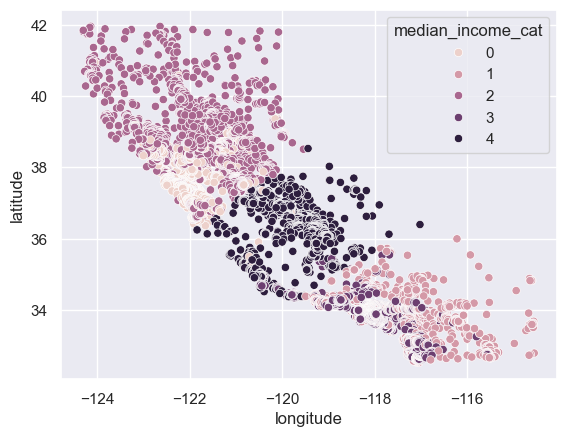

In [19]:
sns.scatterplot(data=df, x='longitude', y='latitude', hue='median_income_cat')

In [20]:
coluna_target=['median_house_value']

coluna_one_hot_encoder=['ocean_proximity', 'median_income_cat']



In [22]:
colunas_robust_scaler = df.columns.difference(coluna_target + coluna_one_hot_encoder)

colunas_standard_scaler=['longitude', 'latitude', 'housing_median_age']

colunas_power_transformer =  df.columns.difference(coluna_target + coluna_one_hot_encoder + colunas_standard_scaler)

Teste do melhor escalonamento para o modelo.

Test of the best scaling of the model

In [24]:
preprocessamento_categoricas =  ColumnTransformer(
    transformers=[
        ('one_hot', OneHotEncoder(drop='first'), coluna_one_hot_encoder),
    ],
    remainder='passthrough' #todas as demais colunas sem alteração
)
preprocessamento_simples =  ColumnTransformer(
    transformers=[
        ('one_hot', OneHotEncoder(drop='first'), coluna_one_hot_encoder),
        ('robust_scaler', RobustScaler(), colunas_robust_scaler),
    ],
)
    #tirar o remainder porque o ribustscaler vai passar por todas as colunas
preprocessamento_completo =  ColumnTransformer(
    transformers=[
        ('one_hot', OneHotEncoder(drop='first'), coluna_one_hot_encoder),
        ('robust_scaler',  RobustScaler(), colunas_standard_scaler),
        ('satandard_scaler', StandardScaler(), colunas_power_transformer),
    ],
)

In [25]:
X=df.drop(columns=coluna_target)
y=df[coluna_target]

In [26]:
X.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity,rooms_per_household,population_per_household,bedrooms_per_room,median_income_cat
0,-122.23,37.88,41.00,880.00,129.00,322.00,126.00,8.33,NEAR BAY,6.98,2.56,0.15,0
1,-122.22,37.86,21.00,7099.00,1106.00,2401.00,1138.00,8.30,NEAR BAY,6.24,2.11,0.16,0
2,-122.26,37.84,42.00,2555.00,665.00,1206.00,595.00,2.08,NEAR BAY,4.29,2.03,0.26,2
3,-122.26,37.85,50.00,1120.00,283.00,697.00,264.00,2.12,NEAR BAY,4.24,2.64,0.25,2
4,-122.26,37.84,50.00,2239.00,455.00,990.00,419.00,1.99,NEAR BAY,5.34,2.36,0.20,2


In [27]:
y.head()

,median_house_value
0,452600.00
1,358500.00
2,226700.00
3,140000.00
4,158700.00


In [28]:
param_grid = {
    'regressor__preprocessor': [preprocessamento_categoricas, preprocessamento_simples, preprocessamento_completo],
    'transformer':[None, PowerTransformer(), QuantileTransformer(output_distribution='normal')]
}

In [29]:
grid_search = grid_search_cv_regressor(
    regressor=LinearRegression(),
    preprocessor=preprocessamento_completo,
    target_transformer=PowerTransformer(),
    param_grid=param_grid,
)
grid_search    

GridSearchCV(cv=KFold(n_splits=5, random_state=42, shuffle=True),
             estimator=TransformedTargetRegressor(regressor=Pipeline(steps=[('preprocessor',
                                                                             ColumnTransformer(transformers=[('one_hot',
                                                                                                              OneHotEncoder(drop='first'),
                                                                                                              ['ocean_proximity',
                                                                                                               'median_income_cat']),
                                                                                                             ('robust_scaler',
                                                                                                              RobustScaler(),
                                                                                                              ['longitude',
                                                                                                               'latitude',
                                                                                                               'housing_median_age']),
                                                                                                             ('satandard_scale...
                                                                                      Index(['bedrooms_per_room', 'households', 'median_income', 'population',
       'population_per_household', 'rooms_per_household', 'total_bedrooms',
       'total_rooms'],
      dtype='object'))])],
                         'transformer': [None, PowerTransformer(),
                                         QuantileTransformer(output_distribution='normal')]},
             refit='neg_root_mean_squared_error',
             scoring=['r2', 'neg_mean_absolute_error',
                      'neg_root_mean_squared_error'],
             verbose=1)

In [30]:
grid_search.fit(X,y)   

Fitting 5 folds for each of 9 candidates, totalling 45 fits


GridSearchCV(cv=KFold(n_splits=5, random_state=42, shuffle=True),
             estimator=TransformedTargetRegressor(regressor=Pipeline(steps=[('preprocessor',
                                                                             ColumnTransformer(transformers=[('one_hot',
                                                                                                              OneHotEncoder(drop='first'),
                                                                                                              ['ocean_proximity',
                                                                                                               'median_income_cat']),
                                                                                                             ('robust_scaler',
                                                                                                              RobustScaler(),
                                                                                                              ['longitude',
                                                                                                               'latitude',
                                                                                                               'housing_median_age']),
                                                                                                             ('satandard_scale...
                                                                                      Index(['bedrooms_per_room', 'households', 'median_income', 'population',
       'population_per_household', 'rooms_per_household', 'total_bedrooms',
       'total_rooms'],
      dtype='object'))])],
                         'transformer': [None, PowerTransformer(),
                                         QuantileTransformer(output_distribution='normal')]},
             refit='neg_root_mean_squared_error',
             scoring=['r2', 'neg_mean_absolute_error',
                      'neg_root_mean_squared_error'],
             verbose=1)

In [31]:
grid_search.best_params_

{'regressor__preprocessor': ColumnTransformer(transformers=[('one_hot', OneHotEncoder(drop='first'),
                                  ['ocean_proximity', 'median_income_cat']),
                                 ('robust_scaler', RobustScaler(),
                                  Index(['bedrooms_per_room', 'households', 'housing_median_age', 'latitude',
        'longitude', 'median_income', 'population', 'population_per_household',
        'rooms_per_household', 'total_bedrooms', 'total_rooms'],
       dtype='object'))]),
 'transformer': QuantileTransformer(output_distribution='normal')}

o  robust scaler apenas teve um resultado melhor que

In [32]:
grid_search.best_score_

-53486.55773943649

In [33]:
coefs=dataframe_coeficientes(
    grid_search.best_estimator_.regressor_['reg'].coef_,
    grid_search.best_estimator_.regressor_['preprocessor'].get_feature_names_out(),
)

In [34]:
coefs

,coeficiente
robust_scaler__longitude,-1.43
robust_scaler__latitude,-1.26
one_hot__median_income_cat_4,-0.38
one_hot__ocean_proximity_INLAND,-0.29
robust_scaler__population_per_household,-0.23
one_hot__ocean_proximity_NEAR BAY,-0.20
robust_scaler__total_bedrooms,-0.11
robust_scaler__total_rooms,-0.09
one_hot__ocean_proximity_NEAR OCEAN,-0.06
robust_scaler__population,-0.05


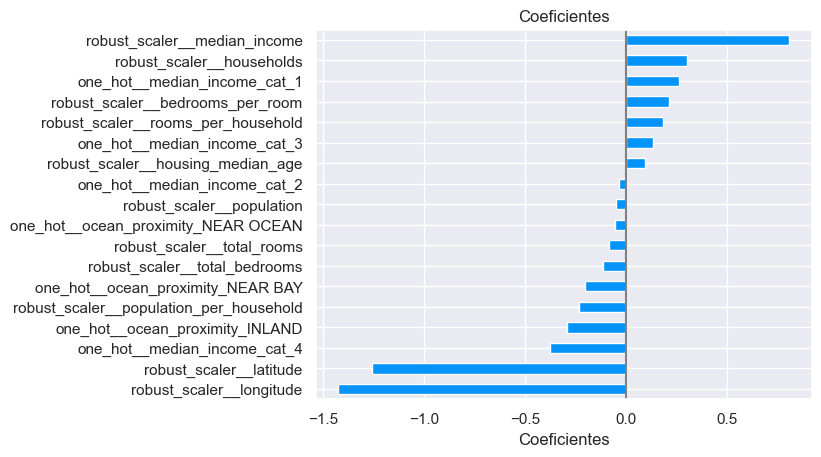

In [35]:
plot_coeficientes(coefs)

In [36]:
target_transformer = PowerTransformer()

regressors = {
    'DummyRegressor':{
        'preprocessor':None,
        'regressor': DummyRegressor(strategy='mean'),
        'target_transformer': None,
    },
    'LinnearRegression':{
        'preprocessor':preprocessamento_categoricas,
        'regressor': LinearRegression(),
        'target_transformer': None,
    },
  
    'LinnearRegression_grid_search':{
        'preprocessor':grid_search.best_estimator_.regressor_['preprocessor'],
        'regressor': grid_search.best_estimator_.regressor_['reg'],
        'target_transformer':grid_search.best_estimator_.transformer,
    },
}    
resultados= {
    nome_modelo: treinar_e_validar_modelo_regressao(X,y,**regressor)
    for nome_modelo, regressor in regressors.items()
}

df_resultados = organiza_resultados(resultados)
df_resultados

,model,fit_time,score_time,test_r2,test_neg_mean_absolute_error,test_neg_root_mean_squared_error,time_seconds
0,DummyRegressor,0.00,0.00,-0.00,-77516.04,-96239.71,0.01
1,DummyRegressor,0.00,0.00,-0.00,-75787.79,-95217.63,0.01
2,DummyRegressor,0.00,0.00,-0.00,-76753.60,-96253.25,0.01
3,DummyRegressor,0.00,0.00,-0.00,-76837.80,-95983.89,0.01
4,DummyRegressor,0.00,0.01,-0.00,-76617.25,-96182.76,0.01
5,LinnearRegression,0.04,0.01,0.69,-39591.78,-53910.63,0.05
6,LinnearRegression,0.03,0.01,0.68,-39985.89,-54260.32,0.04
7,LinnearRegression,0.03,0.02,0.66,-41885.62,-56393.57,0.05
8,LinnearRegression,0.05,0.01,0.67,-40520.95,-54726.20,0.06
9,LinnearRegression,0.04,0.01,0.67,-40434.71,-55019.20,0.05


In [37]:
df_resultados.groupby('model').mean()

,fit_time,score_time,test_r2,test_neg_mean_absolute_error,test_neg_root_mean_squared_error,time_seconds
model,,,,,,
DummyRegressor,0.00,0.00,-0.00,-76702.50,-95975.45,0.01
LinnearRegression,0.04,0.01,0.67,-40483.79,-54861.98,0.05
LinnearRegression_grid_search,0.06,0.02,0.69,-37580.09,-53505.49,0.08


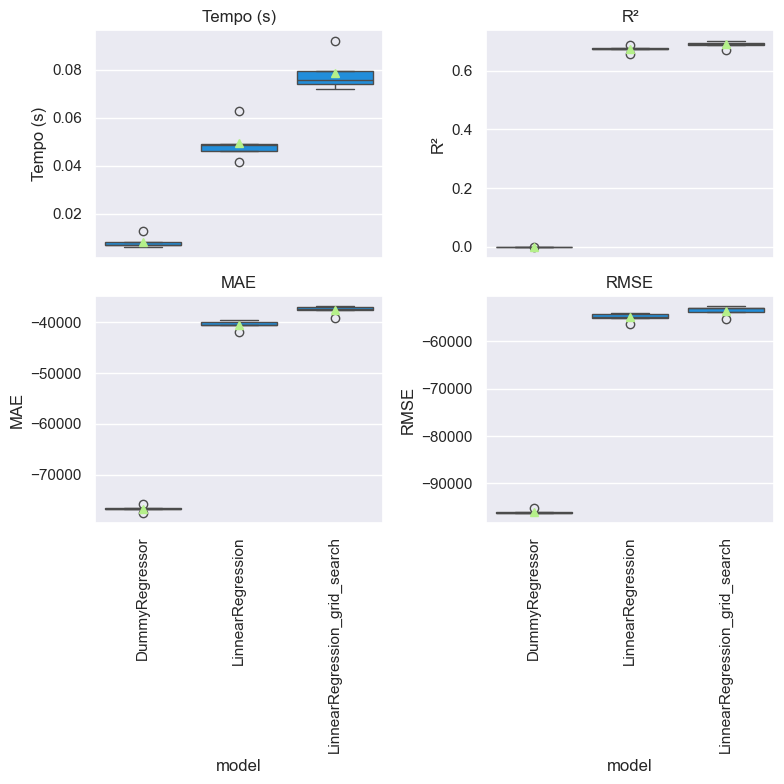

In [38]:
#o linear_regression teve um resultado melhor
plot_comparar_metricas_modelos(df_resultados)

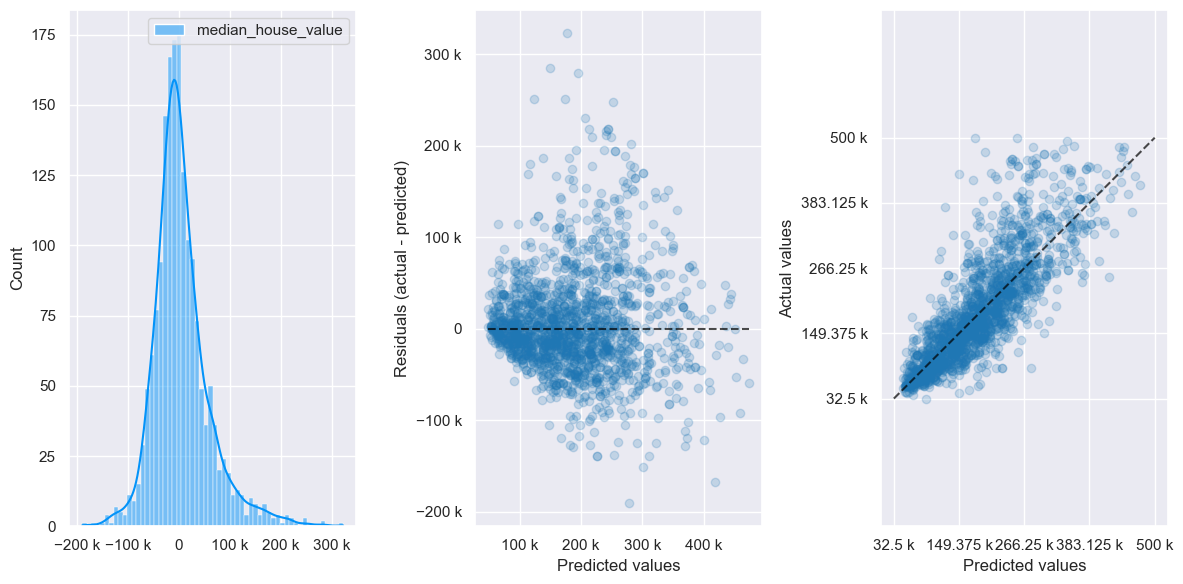

In [39]:
plot_residuos_estimador(grid_search.best_estimator_, X,y, fracao_amostra=0.1, eng_formatter=True)

Conclusão: O RobustScaler se mostrou uma melhor escolha, uma vez que normaliza os dados usando a mediana e o intervalo interquartil (IQR), o que torna o escalonamento robusto a outliers.

Conclusion: RobustScaler proved to be a better choice, as it normalizes the data using the median and interquartile range (IQR), which makes the scaling robust to outliers.